# Google Drive

This first code block attaches your google drive and makes a folder structure. You only need to run this when a new VM is assigned to you. To get your code as a single python file go through the following menus File->'Download .py'.

This also downloads 2 npz files for your use: labels.npz and images.npz. For those not using colab you can download manually here:

https://drive.google.com/open?id=1jIKQLhTHZUE6m2mE5lRKMSqN7ZGK2Gyu

https://drive.google.com/open?id=1Gth_AVG5t-4ZhH_whOaXwe0PBXNhIIK0

https://drive.google.com/file/d/1tkpFDxbpP61OEic7EP4LOhUKclYJLlwr/view?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/drive'
drive.mount(DRIVE_MOUNT)


# create folder to write data to
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2019')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'HW2')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

# bootstrap environment into place
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
import os
from googleapiclient.http import MediaIoBaseDownload

def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    
    downloaded.seek(0)

    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)

    with open(fn, 'wb') as f:
        f.write(downloaded.read())

id_to_fn = {
    '1Gth_AVG5t-4ZhH_whOaXwe0PBXNhIIK0': 'labels.npz',
    '1jIKQLhTHZUE6m2mE5lRKMSqN7ZGK2Gyu': 'images.npz',
    '1mm5mq7ngx5D2QHFedjucyUC3z0VDeSRj': 'test_y_labels.npz',
    '1wuDhxLk2QAmvio-iGVUyLWZbp8DfY8OI': 'test_yolo_loss.npz'      }

# download all files into the vm
for fid, fn in id_to_fn.items():
    download_file(fn, fid)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Data Preprocessing**

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
image_path='/content/images.npz'
labels_path='/content/labels.npz'
def loadData(image_path, labels_path):

  images=np.load(image_path,allow_pickle='True',encoding="latin1")
  imgs=images[images.files[0]]
  labels=np.load(labels_path,allow_pickle='True',encoding="latin1")
  y=labels[labels.files[0]]
  train_images, test_images, train_raw_lables, test_raw_lables = train_test_split(
    imgs, y, train_size=0.8)
  return train_images, train_raw_lables, test_images, test_raw_lables

def create_y_label(image, raw_label):

  y_label=np.zeros((8,8,8))
  for i in raw_label:
    x1,y1,x2,y2=i[1:]
    cx=(x1+x2)/2
    cy=(y1+y2)/2
    grid_x=int(cx/16)
    grid_y=int(cy/16)
    offset_x= (cx % 16)/16
    offset_y=(cy % 16)/16
    w=(x2-x1)/128
    h=(y2-y1)/128
    one_hot=np.zeros(3)
    one_hot[int(i[0])]=1
    y_label[0:5,grid_x,grid_y]=[1,offset_x,offset_y,w,h]
    y_label[5:,grid_x,grid_y]=one_hot
  
  return y_label




In [ ]:
train_imgs,train_labels,test_imgs,test_labels=loadData(image_path,labels_path)



The following test checks your create_y_labels function using the test_y_label.npz file.

In [ ]:

data = np.load("test_y_labels.npz",allow_pickle=True)
## the test data contains 5 - (image, raw_label, processed_label) that is 5 test cases 

img = data['image']   ## shape (5,3,128,18)
raw_label = data['raw_label']
true_y_label = data['y_label']  ## shape (5,8,8,8)


test_label = np.zeros((5,8,8,8))

for i, label in enumerate(raw_label):
  test_label[i] = create_y_label(img[i], label)



for i in range(len(img)):
  comparison = test_label[i] == true_y_label[i]
 
  equal_arrays = comparison.all()
  print('Completed TEST CASE {}: {}'.format(i+1,equal_arrays))


Completed TEST CASE 1: True
Completed TEST CASE 2: True
Completed TEST CASE 3: True
Completed TEST CASE 4: True
Completed TEST CASE 5: True


Test your DATASET

Test your data processing by plotting the images and the processed labels. Compare against the raw labels. 

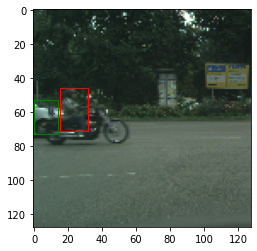

In [ ]:
import torch
import torchvision
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image



image=train_imgs[3]
raw_label=train_labels[3]
fig,ax = plt.subplots(1)
ax.imshow(image)

for i in range(len(raw_label)):
  if raw_label[i][0]==0:
    rect1 = patches.Rectangle((raw_label[i][1],raw_label[i][2]),(raw_label[i][3]-raw_label[i][1]),(raw_label[i][4]-raw_label[i][2]),linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect1)
  if raw_label[i][0]==1:
    rect2 = patches.Rectangle((raw_label[i][1],raw_label[i][2]),(raw_label[i][3]-raw_label[i][1]),(raw_label[i][4]-raw_label[i][2]),linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect2)
  if raw_label[i][0]==2:
    rect3 = patches.Rectangle((raw_label[i][1],raw_label[i][2]),(raw_label[i][3]-raw_label[i][1]),(raw_label[i][4]-raw_label[i][2]),linewidth=1,edgecolor='g',facecolor='none')
    ax.add_patch(rect3)

plt.show()


### **Visualizing Channels**

Channel  0  : Objectness


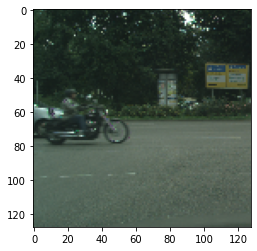

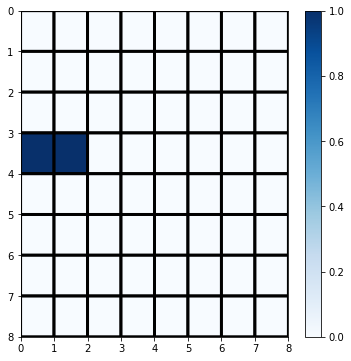

Channel  1  : x


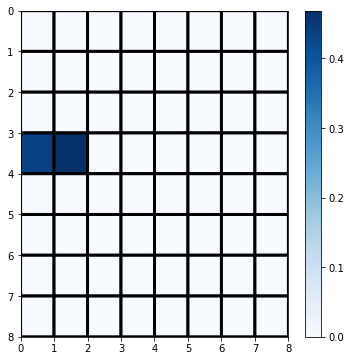

Channel  2  : y


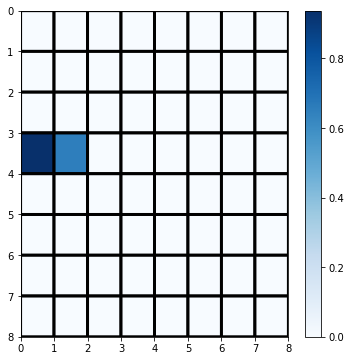

Channel  3  : w


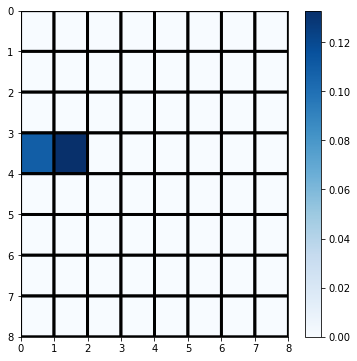

Channel  4  : h


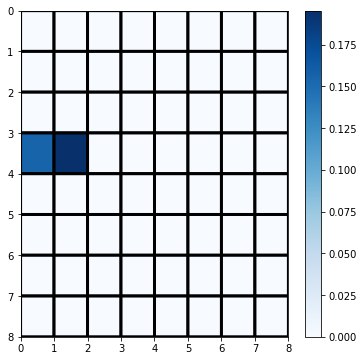

Channel  5  : P(class=pedestrian)


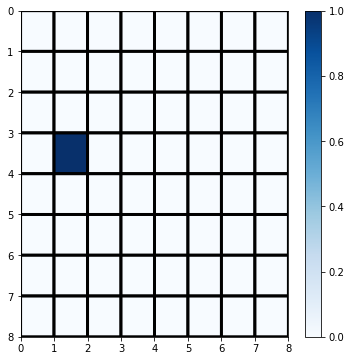

Channel  6  : P(class=traffic light)


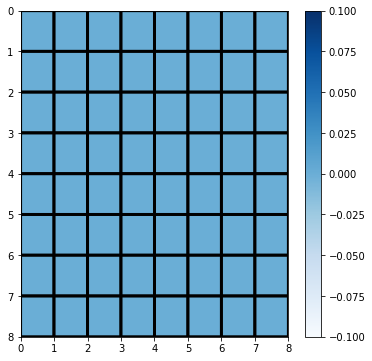

Channel  7  : P(class=car)


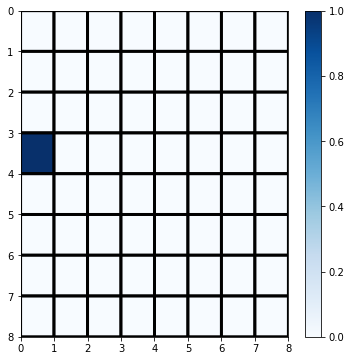

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import Normalize
processed_label = create_y_label(train_imgs[3], train_labels[3])

fig,ax = plt.subplots(1)
ax.imshow(image)

features=['Objectness','x','y','w','h','P(class=pedestrian)','P(class=traffic light)', 'P(class=car)']
for i in range(8):

  print("Channel ",i," :",features[i])
  cmap = colors.ListedColormap(['Green','Red'])
  plt.figure(figsize=(6,6))
  plt.gca().invert_yaxis()
  plt.pcolor(processed_label[i].T,cmap='Blues',edgecolors='k', linewidths=3)
  plt.colorbar()
  plt.show()




(128, 128, 3) (2, 5)


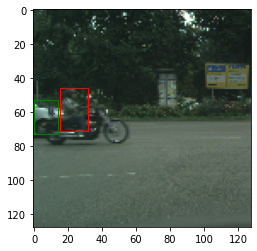

In [ ]:
import torch
import torchvision
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

image=train_imgs[3]
raw_label=train_labels[3]

fig,ax = plt.subplots(1)
ax.imshow(image)
label=create_y_label(image,raw_label)
print(image.shape, raw_label.shape)

for i in range(8):
  label[i]=label[i].T

for i in range(8):
  for j in range(8):
    if label[0][i][j]>0.5:
      if label[5][i][j]>0.5:
        w = label[3][i][j]*128
        h = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 -w/2
        y_coord = label[2][i][j]*16 + i*16 - h/2
        rect1 = patches.Rectangle((x_coord,y_coord),w,h,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect1)
      if label[6][i][j]>0.5:
        w = label[3][i][j]*128
        h = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 - w/2
        y_coord = label[2][i][j]*16 + i*16 - h/2
        rect2 = patches.Rectangle((x_coord,y_coord),w,h,linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect2)
      if label[7][i][j]>0.5:
        w = label[3][i][j]*128
        h = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 - w/2
        y_coord = label[2][i][j]*16 + i*16 - h/2
        rect3 = patches.Rectangle((x_coord,y_coord),w,h,linewidth=1,edgecolor='g',facecolor='none')
        ax.add_patch(rect3)
       
plt.show()




### **PyTorch Dataset**

In [ ]:
new_trainimgs=np.zeros((len(train_labels),3,128,128))
new_testimgs=np.zeros((len(test_labels),3,128,128))
new_trainlabels=np.zeros((len(train_labels),8,8,8))
new_testlabels=np.zeros((len(test_labels),8,8,8))
for i in range(len(train_labels)):
  new_trainlabels[i]=create_y_label(train_imgs[i],train_labels[i])
  new_trainimgs[i] = train_imgs[i].transpose((2,0,1))
for i in range((len(test_labels))): 
  new_testlabels[i]=create_y_label(test_imgs[i],test_labels[i])
  new_testimgs[i]=test_imgs[i].transpose((2,0,1))


new_trainimgs= torch.from_numpy(new_trainimgs)
new_testimgs= torch.from_numpy(new_testimgs)
new_trainlabels=torch.from_numpy(new_trainlabels)
new_testlabels=torch.from_numpy(new_testlabels)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

BATCH_SIZE = 64


transform=torchvision.transforms.Compose([torchvision.transforms.Normalize((0.5,), (0.5,))])

for i in range(len(train_labels)):
  new_trainimgs[i]=transform(new_trainimgs[i])
for i in range(len(test_labels)):
  new_testimgs[i]=transform(new_testimgs[i])


train_dataset = TensorDataset(new_trainimgs, new_trainlabels)
test_dataset = TensorDataset(new_testimgs, new_testlabels)

train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE, shuffle=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 128, 128])
torch.Size([8, 8, 8])


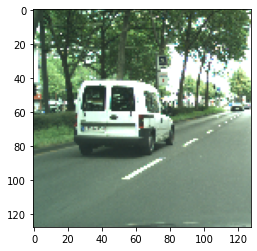

In [ ]:

for idx,data in enumerate(train_loader):
  image,label=data
  plt.imshow(image[idx].numpy().transpose((1,2,0)).astype('long'))
  if(idx==5):
    print(image.shape)
    print(label[idx].shape)
    plt.show()
    break

### **Model Definition**

In [ ]:
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
class YOLO(torch.nn.Module):
  def __init__(self):
    super(YOLO, self).__init__()
    self.features = nn.Sequential(
          nn.Conv2d(3, 32, kernel_size=4,stride = 2, padding=(1,1)),         
          nn.BatchNorm2d(32),
          nn.ReLU(), 
          nn.Conv2d(32, 64,  kernel_size=4,stride = 2, padding=(1,1)),         
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(64, 128,  kernel_size=4,stride = 2, padding=(1,1)),         
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Conv2d(128, 256,  kernel_size=4,stride = 2, padding=(1,1)),         
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.Conv2d(256, 512,  kernel_size=4,stride = 2, padding=(1,1)),         
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.Conv2d(512, 1024,  kernel_size=4,stride = 2, padding=(1,1)),         
          nn.BatchNorm2d(1024),
          nn.ReLU(),
          nn.ConvTranspose2d(1024, 256,  kernel_size=4,stride = 2, padding=(1,1)),         
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.ConvTranspose2d(256, 64,  kernel_size=4,stride = 2, padding=(1,1)),         
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(64, 8,  kernel_size=3,stride = 1, padding=(1,1)),   
                       
      )

  def forward(self, x):
    x = F.sigmoid(self.features(x))
    return x


### **YOLO loss function**

In [ ]:
def IOU(bbox_1 ,bbox_2):
  x_1up=bbox_1[0]
  y_1up=bbox_1[1]
  x_1l=bbox_1[2]
  y_1l=bbox_1[3]

  x_2up=bbox_2[0]
  y_2up=bbox_2[1]
  x_2l=bbox_2[2]
  y_2l=bbox_2[3]

 
  x_up=max(x_1up,x_2up)
  y_up=max(y_1up,y_2up)
  x_l=min(x_1l,x_2l)
  y_l=min(y_1l,y_2l)

  inter_area=max((x_l-x_up+1),0)*max((y_l-y_up+1),0)
  area_box1=(x_1l-x_1up+1)*(y_1l-y_1up+1)
  area_box2=(x_2l-x_2up+1)*(y_2l-y_2up+1)
  union_area=area_box1+area_box2-inter_area
  iou=inter_area/float(union_area)
  return iou


def decode_box_1(code,objects):
  box=torch.zeros(4)
  x,y,w,h=code[1:5]
  re_w=w*128
  re_h=h*128
  re_x=x*16
  re_y=y*16
  grid_x=objects[1]
  grid_y=objects[2]
  box[0]=grid_x*16+re_x-re_w/2
  box[1]=grid_y*16+re_y-re_h/2
  box[2]=grid_x*16+re_x+re_w/2
  box[3]=grid_y*16+re_y+re_h/2
  return box
  

def calc_confidence_score(prediction, grnd_truth,objects):
  
  num_objects=prediction.shape[0]
  
  C_true=torch.zeros(num_objects)
  for i in range(num_objects):
  
    predicted_bbox = decode_box_1(prediction[i,:],objects[i,:])
    
    grnd_truth_bbox= decode_box_1(grnd_truth[i,:],objects[i,:])

    iou = IOU(predicted_bbox,grnd_truth_bbox )
    C_true[i] = iou
    
  return C_true


In [ ]:
def YoloLoss(outputs, target, lambda_coord, lambda_noobj):
 
  objects=target[:,0,:,:].nonzero()

  non_objects=(target[:,0,:,:]==0).nonzero()
 
  target_objects=target[objects[:,0],:,objects[:,1],objects[:,2]]

  predicted_objects=outputs[objects[:,0],:,objects[:,1],objects[:,2]]
  non_predicted_objects=outputs[non_objects[:,0],:,non_objects[:,1],non_objects[:,2]]

  l1 = torch.sum(target[:,0,:,:]*((target[:,1,:,:] - outputs[:,1,:,:])**2 + (target[:,2,:,:] - outputs[:,2,:,:])**2))
  l2 = torch.sum(target[:,0,:,:]*((torch.sqrt(target[:,3,:,:]) - torch.sqrt(outputs[:,3,:,:]))**2 + (torch.sqrt(target[:,4,:,:]) - torch.sqrt(outputs[:,4,:,:]))**2))

  conf=calc_confidence_score(predicted_objects,target_objects,objects)
  
  l3 = torch.sum((1-predicted_objects[:,0].cuda())**2)

  l4 = torch.sum((0-non_predicted_objects[:,0])**2)

  l5 = torch.sum(target[:,0,:,:]*((target[:,5,:,:] - outputs[:,5,:,:])**2 + (target[:,6,:,:] - outputs[:,6,:,:])**2 + (target[:,7,:,:] - outputs[:,7,:,:])**2))

  return lambda_coord*(l1+l2)+l3+lambda_noobj*l4+l5



In [ ]:
device = torch.device("cuda")
Network=YOLO()
Network.cuda()
optimizer = optim.Adam(Network.parameters(), lr=10e-5 ,weight_decay=0.0001)
lambda_coord= torch.Tensor([5]).to(device)
lambda_noobj =torch.Tensor([0.5]).to(device)

### **Loss Test**

In [ ]:
import numpy as np
import pdb
import torch

#path = os.path.join(HOMEWORK_FOLDER,'test_yolo_loss.npz')
data = np.load('test_yolo_loss.npz',allow_pickle=True)

## the test data contains 10 - (predicted_ouput, target, true_loss) that is 10 test cases 

predicted = data['pred']   ## shape (10,1,8,8,8)
target = data['target']   ## shape (10,1,8,8,8)
true_loss = data['loss']  ## shape (10,)

for i  in range(len(predicted)):
  computed_loss = YoloLoss(torch.from_numpy(predicted[i,:,:,:,:]), torch.from_numpy(target[i,:,:,:,:]), lambda_coord= 5, lambda_noobj =0.5)
  print('TEST CASE {}: Computed Loss - {} Loss - {}'.format(i+1,computed_loss, true_loss[i]))

TEST CASE 1: Computed Loss - 8.638099670410156 Loss - 8.570581859398414
TEST CASE 2: Computed Loss - 6.854546546936035 Loss - 6.800624567771324
TEST CASE 3: Computed Loss - 9.870726585388184 Loss - 9.830386627684668
TEST CASE 4: Computed Loss - 8.135767936706543 Loss - 8.104469495911465
TEST CASE 5: Computed Loss - 9.580194473266602 Loss - 9.56554696444006
TEST CASE 6: Computed Loss - 5.269013404846191 Loss - 5.181439780422893
TEST CASE 7: Computed Loss - 1.6634485721588135 Loss - 1.6365162407967868
TEST CASE 8: Computed Loss - 7.263216018676758 Loss - 7.215272422683144
TEST CASE 9: Computed Loss - 5.722009658813477 Loss - 5.683797272216336
TEST CASE 10: Computed Loss - 8.79401969909668 Loss - 8.74894558115439


### **Training**

In [ ]:
trainloss=[]
epoch_count=[]

In [ ]:
path = '/content/drive/My Drive/yolo_epoch95' # set this to where the checkpoint is saved 
resume = True # set this True if you want to resume training from a checkpoint

yolo_net=YOLO()
device = torch.device("cuda")## initilize device to cpu or cuda
yolo_net=yolo_net.to(device)

learning_rate = 10e-5
lambda_coord= torch.Tensor([5]).to(device)
lambda_noobj =torch.Tensor([0.5]).to(device)
## intialize optimizer
optimizer=torch.optim.Adam(yolo_net.parameters(),lr=learning_rate,weight_decay=0.0001)

if resume == False:
  checkpoint = torch.load(path)
  yolo_net.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epochs = checkpoint['epoch']
  
num_epochs = 60 ## intialize this, atleast 20 epoch required for training
 
for epochs in range(num_epochs):
  ## fill in your training code
  yolo_net.train()
  correct=0
  overall_loss = 0
  total = 0
  for idx,(data,target) in enumerate(train_loader):
    data=data.float()
    data,target = data.to(device),target.to(device)
    optimizer.zero_grad()
    output = yolo_net(data)
    output=output.cuda()
    target=target.cuda()
    loss = YoloLoss(output, target, lambda_coord.cuda(), lambda_noobj.cuda()).cuda()
    overall_loss+=loss.item()
    loss.backward()
    optimizer.step()
    print(epochs,"Train loss",loss)
  train_loss = overall_loss/(idx+1)
  trainloss.append(train_loss)
  epoch_count.append(epochs)
  
  ## this is sample code for saving checkpoints, please set the appropriate path, 
  ## additional values and feel free to move the snippet if required.
  path = os.path.join('','yolo_epoch'+str(epochs+73))
  torch.save({
            'epoch': epochs,
            'model_state_dict': yolo_net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    



### **Post Processing- NMS and MAP**

In [ ]:
def decode_box(x,y,w,h,j,i):
  box=torch.zeros(4)
  re_w=w*128
  re_h=h*128
  re_x=x*16
  re_y=y*16
  box[0]=j*16+re_x-re_w/2
  box[1]=j*16+re_y+re_w/2
  box[2]=i*16+re_x-re_h/2
  box[3]=i*16+re_y+re_h/2
  return box

In [ ]:
def IOU(bbox_1 ,bbox_2):
  x_up=max(bbox_1[0],bbox_2[0])
  y_up=max(bbox_1[1],bbox_2[1])
  x_l=min(bbox_1[2],bbox_2[2])
  y_l=min(bbox_1[3],bbox_2[3])

  inter_area=max((x_l-x_up+1),0)*max((y_l-y_up+1),0)
  area_box1=(bbox_1[2]-bbox_1[0]+1)*(bbox_1[3]-bbox_1[1]+1)
  area_box2=(bbox_2[2]-bbox_2[0]+1)*(bbox_2[3]-bbox_2[1]+1)
  union_area=area_box1+area_box2-inter_area
  iou=inter_area/float(union_area)
  return iou

### **NMS( Non Max Suppression)**

In [ ]:
def nms(label):
  for k in range(5,8):
    for i in range(8):
      for j in range(8):
        if label[0][i][j]>0.6:
          bbox_1=decode_box(label[1][i][j],label[2][i][j],label[3][i][j],label[4][i][j],j,i)
          for p in range(8):
            for q in range(8):
              if label[0][p][q]>0.6:
                if(p!=i and q!=j):
                  bbox_2=decode_box(label[1][p][q],label[2][p][q],label[3][p][q],label[4][p][q],q,p)
                  iou = IOU(bbox_1,bbox_2)
                  if iou > 0.5:
                    if label[k][i][j]>label[k][p][q]:
                      label[0][p][q] = 0
                    elif label[k][i][j]<label[k][p][q]:
                      label[0][i][j] = 0
  return label

### **Mean Average Precision**

In [ ]:
def yolo_evaluation(label,target):
  true_1=0
  true_2=0
  true_3=0
  bbox_1=0
  bbox_2=0
  a=torch.zeros(3)
  c=torch.zeros(3)

  for i in range(8):
    for j in range(8):
      if (target[0][i][j]==1):
        bbox_1=decode_box(label[1][i][j],label[2][i][j],label[3][i][j],label[4][i][j],j,i)
        bbox_2=decode_box(target[1][i][j],target[2][i][j],target[3][i][j],target[4][i][j],j,i)
        a[0]=label[5][i][j]
        a[1]=label[6][i][j]
        a[2]=label[7][i][j]
        _,b=torch.max(a,0)
        c[0]=target[5][i][j]
        c[1]=target[6][i][j]
        c[2]=target[7][i][j]
        _,d=torch.max(c,0)
        if (b==0 and d!=0):
          match_1.append(0)
          score_1.append(IOU(bbox_1 ,bbox_2))
        elif (b==0 and d==0 and IOU(bbox_1 ,bbox_2)>0.5):
          match_1.append(1)
          score_1.append(IOU(bbox_1 ,bbox_2))
        elif (b==0 and d==0 and IOU(bbox_1 ,bbox_2)<0.5):   
          match_1.append(0)
          score_1.append(IOU(bbox_1 ,bbox_2))
        if (b==1 and d!=1):
          match_2.append(0)
          score_2.append(IOU(bbox_1 ,bbox_2))  
        elif (b==1 and d==1 and IOU(bbox_1 ,bbox_2)>0.5):
          match_2.append(1)
          score_2.append(IOU(bbox_1 ,bbox_2))
        elif (b==1 and d==1 and IOU(bbox_1 ,bbox_2)<0.5):   
          match_2.append(0)
          score_2.append(IOU(bbox_1 ,bbox_2))
        if (b==2 and d!=2):
          match_3.append(0)
          score_3.append(IOU(bbox_1 ,bbox_2)) 
        elif (b==2 and d==2 and IOU(bbox_1 ,bbox_2)>0.5):
          match_3.append(1)
          score_3.append(IOU(bbox_1 ,bbox_2))
        elif (b==2 and d==2 and IOU(bbox_1 ,bbox_2)<0.5):   
          match_3.append(0)
          score_3.append(IOU(bbox_1 ,bbox_2))         
        if (d==0):
          true_1+=1
        elif (d==1):
          true_2+=1
        elif (d==2):
          true_3+=1   
        
            
  return match_1, match_2, match_3,score_1,score_2,score_3,true_1,true_2,true_3

### **TESTING**

In [ ]:
from sklearn.metrics import auc
def average_precision(match, score, true):
  tot_pos=0
  TP=0
  maximum_score= np.max(score)
  ln= np.linspace(0.6,maximum_score,num=100)
  precision_mat= np.zeros((101))
  recall_mat= np.zeros((101))
  for i in range(len(ln)):
    tot_pos=0
    TP=0
    th=ln[i]
    for j in range(len(match)):
      if (match[j]==1):
        tot_pos+=1
        if (score[j]>th):
          TP+=1
    precision=1
    if tot_pos>0:
      precision=TP/tot_pos
      recall=1
    if true>0:
      recall=TP/true
    precision_mat[i]=precision
    recall_mat[i]=recall
  recall_mat[100]=0
  sorted_ind=np.argsort(recall_mat)
  sorted_recall=recall_mat[sorted_ind]
  sorted_precision=precision_mat
  area=auc(sorted_recall,sorted_precision)
  return area,sorted_precision,sorted_recall

In [ ]:
epoch_count=[]
mean_avg_precision=[]
avg_precision_pedestrian=[]
avg_precision_traffic=[]
avg_precision_car=[]

In [ ]:
path = '/content/drive/My Drive/yolo_epoch95' # set this to where the checkpoint is saved 
resume = False # set this True if you want to resume training from a checkpoint


yolo_net=YOLO()
device = torch.device("cuda")## initilize device to cpu or cuda
yolo_net=yolo_net.to(device)

learning_rate = 10e-5
lambda_coord= torch.Tensor([5]).to(device)
lambda_noobj =torch.Tensor([0.5]).to(device)
## intialize optimizer
optimizer=torch.optim.Adam(yolo_net.parameters(),lr=learning_rate,weight_decay=0.0001)

if resume == True:
  checkpoint = torch.load(path)
  yolo_net.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epochs = checkpoint['epoch']
  
num_epochs = 100 ## intialize this, atleast 20 epoch required for training
 
for epochs in range(num_epochs):
  ## fill in your training code
  yolo_net.train()
  correct=0
  overall_loss = 0
  total = 0
  for idx,(data,target) in enumerate(train_loader):
    data=data.float()
    data,target = data.to(device),target.to(device)
    optimizer.zero_grad()
    output = yolo_net(data)
    output=output.cuda()
    target=target.cuda()
    loss = YoloLoss(output, target, lambda_coord.cuda(), lambda_noobj.cuda()).cuda()
    overall_loss+=loss.item()
    loss.backward()
    optimizer.step()
    print(epochs,"Train loss",loss)
  total_trues_1=0
  total_trues_2=0
  total_trues_3=0
  match_1=[]
  match_2=[]
  match_3=[]
  score_1=[]
  score_2=[]
  score_3=[]
  true_1=0
  true_2=0
  true_3=0
  with torch.no_grad():
    yolo_net.eval()
    for idx,(data,target) in enumerate(test_loader):
      data=data.float()
      data=data.to(device)
      optimizer.zero_grad()
      output=yolo_net(data)
      for i in range(len(output)):
        output[i]=nms(output[i])
        match_1, match_2, match_3,score_1,score_2,score_3,true_1,true_2,true_3=yolo_evaluation(output[i],target[i])
        total_trues_1+=true_1
        total_trues_2+=true_2
        total_trues_3+=true_3
    cnt=0
    AP=0
    if len(match_1)>0:
      AP1,_,_=average_precision(match_1,score_1,total_trues_1)
      cnt+=1
    if len(match_2)>0:
      AP2,_,_=average_precision(match_2,score_2,total_trues_2)
      cnt+=1
    if len(match_3)>0:
      AP3,_,_=average_precision(match_3,score_3,total_trues_3)
      cnt+=1
    if cnt>0:
      mAp = (AP1+AP2+AP3)/cnt
      epoch_count.append(epochs)
      mean_avg_precision.append(mAp)
      avg_precision_pedestrian.append(AP1)
      avg_precision_traffic.append(AP2)
      avg_precision_car.append(AP3)

  ## this is sample code for saving checkpoints, please set the appropriate path, 
  ## additional values and feel free to move the snippet if required.
  path = os.path.join('','yolo_epoch'+str(epochs+73))
  torch.save({
            'epoch': epochs,
            'model_state_dict': yolo_net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
    



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Streaming output truncated to the last 5000 lines.
13 Train loss tensor([15.0882], device='cuda:0', grad_fn=<AddBackward0>)
13 Train loss tensor([15.4575], device='cuda:0', grad_fn=<AddBackward0>)
13 Train loss tensor([13.7012], device='cuda:0', grad_fn=<AddBackward0>)
13 Train loss tensor([11.2308], device='cuda:0', grad_fn=<AddBackward0>)
13 Train loss tensor([19.2237], device='cuda:0', grad_fn=<AddBackward0>)
13 Train loss tensor([15.7159], device='cuda:0', grad_fn=<AddBackward0>)
13 Train loss tensor([17.3023], device='cuda:0', grad_fn=<AddBackward0>)
13 Train loss tensor([14.8298], device='cuda:0', grad_fn=<AddBackward0>)
13 Train loss tensor([13.4017], device='cuda:0', grad_fn=<AddBackward0>)
13 Train loss tensor([19.0997], device='cuda:0', grad_fn=<AddBackward0>)
13 Train loss tensor([14.2608], device='cuda:0', grad_fn=<AddBackward0>)
13 Train loss tensor([12.9437], device='cuda:0', grad_fn=<AddBackward0>)
13 Train loss tensor([15.8228], device='cuda:0', grad_fn=<AddBackward0>)


KeyboardInterrupt: ignored

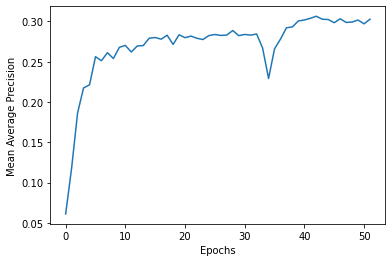

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epoch_count,mean_avg_precision)
plt.ylabel('Mean Average Precision')
plt.xlabel('Epochs')
plt.show()

In [ ]:
print(mean_avg_precision[-1])

0.302689703594242


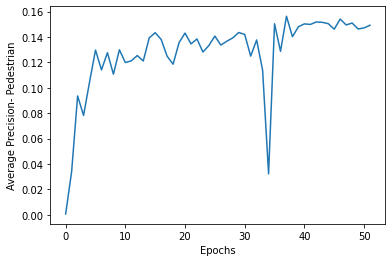

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epoch_count,avg_precision_pedestrian)
plt.ylabel('Average Precision- Pedestrian')
plt.xlabel('Epochs')
plt.show()

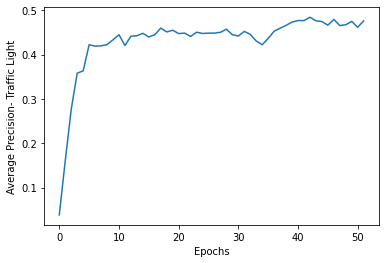

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epoch_count,avg_precision_traffic)
plt.ylabel('Average Precision- Traffic Light')
plt.xlabel('Epochs')
plt.show()

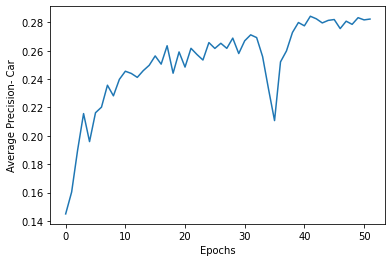

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epoch_count,avg_precision_car)
plt.ylabel('Average Precision- Car')
plt.xlabel('Epochs')
plt.show()

### **INFERENCE**

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 128, 128])


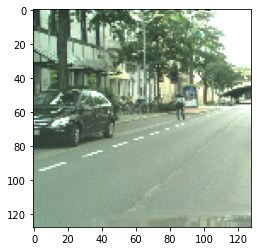

In [ ]:
with torch.no_grad():
  yolo_net.eval()
  for idx,(data,target) in enumerate(test_loader):
    data=data.float()
    data=data.to(device)
    optimizer.zero_grad()
    output=yolo_net(data)
    break
plt.imshow(data[15].cpu().numpy().transpose((1,2,0)).astype('long'))
print(data.shape)
plt.show()


### **No Elimination**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


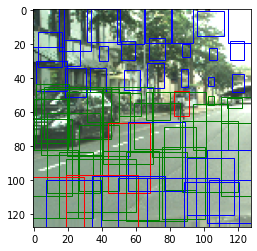

In [ ]:
import torch
import torchvision
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
image=data[15].cpu().numpy().transpose((1,2,0)).astype('long')

fig,ax = plt.subplots(1)
ax.imshow(image)
label=output[15]
for i in range(8):
  label[i]=label[i].T

for i in range(8):
  for j in range(8):
    if label[0][i][j]>=0:
      if label[5][i][j]>=0 and label[5][i][j]>label[6][i][j] and label[5][i][j]>label[7][i][j]:
        w = label[3][i][j]*128
        h = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 -w/2
        y_coord = label[2][i][j]*16 + i*16 - h/2
        rect1 = patches.Rectangle((x_coord,y_coord),w,h,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect1)
      if label[6][i][j]>=0 and label[6][i][j]>label[5][i][j] and label[6][i][j]>label[7][i][j]:
        w = label[3][i][j]*128
        h = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 - w/2
        y_coord = label[2][i][j]*16 + i*16 - h/2
        rect2 = patches.Rectangle((x_coord,y_coord),w,h,linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect2)
      if label[7][i][j]>=0 and label[7][i][j]>label[6][i][j] and label[7][i][j]>label[5][i][j]:
        w = label[3][i][j]*128
        h = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 - w/2
        y_coord = label[2][i][j]*16 + i*16 - h/2
        rect3 = patches.Rectangle((x_coord,y_coord),w,h,linewidth=1,edgecolor='g',facecolor='none')
        ax.add_patch(rect3)
       
plt.show()




### **Low probability bounding boxes removed**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


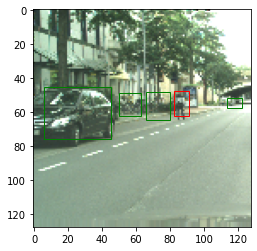

In [ ]:
import torch
import torchvision
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
image=data[15].cpu().numpy().transpose((1,2,0)).astype('long')

fig,ax = plt.subplots(1)
ax.imshow(image)
label=output[15]
for i in range(8):
  label[i]=label[i].T

for i in range(8):
  for j in range(8):
    if label[0][i][j]>0.6:
      if label[5][i][j]>0 and label[5][i][j]>label[6][i][j] and label[5][i][j]>label[7][i][j]:
        w = label[3][i][j]*128
        h = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 -w/2
        y_coord = label[2][i][j]*16 + i*16 - h/2
        rect1 = patches.Rectangle((x_coord,y_coord),w,h,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect1)
      if label[6][i][j]>0 and label[6][i][j]>label[5][i][j] and label[6][i][j]>label[7][i][j]:
        w = label[3][i][j]*128
        h = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 - w/2
        y_coord = label[2][i][j]*16 + i*16 - h/2
        rect2 = patches.Rectangle((x_coord,y_coord),w,h,linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect2)
      if label[7][i][j]>0 and label[7][i][j]>label[6][i][j] and label[7][i][j]>label[5][i][j]:
        w = label[3][i][j]*128
        h = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 - w/2
        y_coord = label[2][i][j]*16 + i*16 - h/2
        rect3 = patches.Rectangle((x_coord,y_coord),w,h,linewidth=1,edgecolor='g',facecolor='none')
        ax.add_patch(rect3)
       
plt.show()


### **After NMS**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.5312, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.000

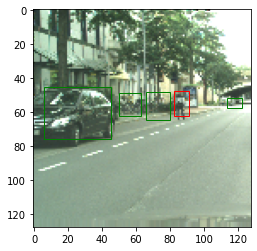

In [ ]:
import torch
import torchvision
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
image=data[15].cpu().numpy().transpose((1,2,0)).astype('long')
fig,ax = plt.subplots(1)
label_new=nms(output[15])
label=label_new
print(target[15])
ax.imshow(image)
for i in range(8):
  label[i]=label[i].T
for i in range(8):
  for j in range(8):
    if(label[0][i][j]>0.6):
      if label[5][i][j]>0 and label[5][i][j]>label[6][i][j] and label[5][i][j]>label[7][i][j]:
        width = label[3][i][j]*128
        height = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 -width/2
        y_coord = label[2][i][j]*16 + i*16 - height/2
        rect1 = patches.Rectangle((x_coord,y_coord),width,height,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect1)
      if label[6][i][j]>0 and label[6][i][j]>label[5][i][j] and label[6][i][j]>label[7][i][j]:
        width = label[3][i][j]*128
        height = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 - width/2
        y_coord = label[2][i][j]*16 + i*16 - height/2
        rect2 = patches.Rectangle((x_coord,y_coord),width,height,linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect2)
      if label[7][i][j]>0 and label[7][i][j]>label[6][i][j] and label[7][i][j]>label[5][i][j]:
        width = label[3][i][j]*128
        height = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 - width/2
        y_coord = label[2][i][j]*16 + i*16 - height/2
        rect3 = patches.Rectangle((x_coord,y_coord),width,height,linewidth=1,edgecolor='g',facecolor='none')
        ax.add_patch(rect3)
        
        
plt.show()

### **PRECISION/RECALL CURVES**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.1875, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.000

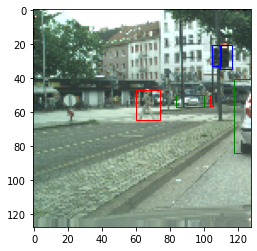

In [ ]:
import torch
import torchvision
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
image=data[15].cpu().numpy().transpose((1,2,0)).astype('long')
fig,ax = plt.subplots(1)
label_new=nms(output[15])
label=label_new
print(target[15])
ax.imshow(image)
for i in range(8):
  label[i]=label[i].T
for i in range(8):
  for j in range(8):
    if(label[0][i][j]>0.6):
      if label[5][i][j]>0 and label[5][i][j]>label[6][i][j] and label[5][i][j]>label[7][i][j]:
        width = label[3][i][j]*128
        height = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 -width/2
        y_coord = label[2][i][j]*16 + i*16 - height/2
        rect1 = patches.Rectangle((x_coord,y_coord),width,height,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect1)
      if label[6][i][j]>0 and label[6][i][j]>label[5][i][j] and label[6][i][j]>label[7][i][j]:
        width = label[3][i][j]*128
        height = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 - width/2
        y_coord = label[2][i][j]*16 + i*16 - height/2
        rect2 = patches.Rectangle((x_coord,y_coord),width,height,linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect2)
      if label[7][i][j]>0 and label[7][i][j]>label[6][i][j] and label[7][i][j]>label[5][i][j]:
        width = label[3][i][j]*128
        height = label[4][i][j]*128
        x_coord = label[1][i][j]*16 + j*16 - width/2
        y_coord = label[2][i][j]*16 + i*16 - height/2
        rect3 = patches.Rectangle((x_coord,y_coord),width,height,linewidth=1,edgecolor='g',facecolor='none')
        ax.add_patch(rect3)
        
        
plt.show()

In [ ]:
total_trues_1=0
total_trues_2=0
total_trues_3=0
match_1=[]
match_2=[]
match_3=[]
score_1=[]
score_2=[]
score_3=[]
true_1=0
true_2=0
true_3=0
with torch.no_grad():
  yolo_net.eval()
  for idx,(data,target) in enumerate(test_loader):
    data=data.float()
    data=data.to(device)
    optimizer.zero_grad()
    output=yolo_net(data)
    for i in range(len(output)):
      output[i]=nms(output[i])
      print(i)
      match_1, match_2, match_3,score_1,score_2,score_3,true_1,true_2,true_3=yolo_evaluation(output[i],target[i])
      total_trues_1+=true_1
      total_trues_2+=true_2
      total_trues_3+=true_3

In [ ]:
from sklearn.metrics import auc
def average_precision(match, score, true):
  tot_pos=0
  TP=0
  maximum_score= np.max(score)
  ln= np.linspace(0.6,maximum_score,num=100)
  precision_mat= np.zeros((101))
  recall_mat= np.zeros((101))
  for i in range(len(ln)):
    tot_pos=0
    TP=0
    th=ln[i]
    for j in range(len(match)):
      if (match[j]==1):
        tot_pos+=1
        if (score[j]>th):
          TP+=1
    precision=1
    if tot_pos>0:
      precision=TP/tot_pos
      recall=1
    if true>0:
      recall=TP/true
    precision_mat[i]=precision
    recall_mat[i]=recall
  recall_mat[100]=0
  sorted_ind=np.argsort(recall_mat)
  sorted_recall=recall_mat[sorted_ind]
  sorted_precision=precision_mat
  area=auc(sorted_recall,sorted_precision)
  return area,sorted_precision,sorted_recall

In [ ]:
cnt=0
AP=0
if len(match_1)>0:
  AP1,_,_=average_precision(match_1,score_1,total_trues_1)
  cnt+=1
if len(match_2)>0:
  AP2,_,_=average_precision(match_2,score_2,total_trues_2)
  cnt+=1
if len(match_3)>0:
  AP3,_,_=average_precision(match_3,score_3,total_trues_3)
  cnt+=1
if cnt>0:
  mAp = (AP1+AP2+AP3)/cnt

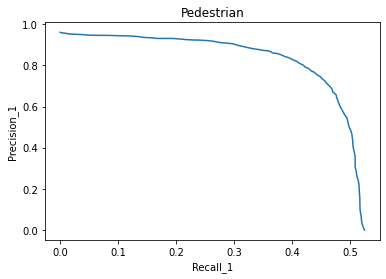

In [ ]:
import matplotlib.pyplot as plt
plt.plot(sorted_recall_1,sorted_precision_1)
plt.title('Pedestrian')
plt.ylabel('Precision_1')
plt.xlabel('Recall_1')
plt.show()

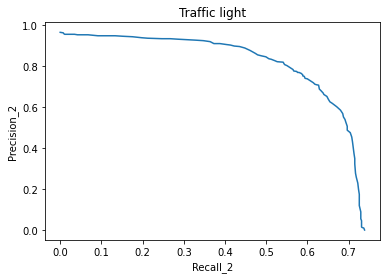

In [ ]:
import matplotlib.pyplot as plt
plt.plot(sorted_recall_2,sorted_precision_2)
plt.title('Traffic light')
plt.ylabel('Precision_2')
plt.xlabel('Recall_2')
plt.show()

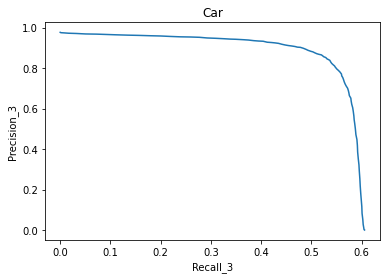

In [ ]:
import matplotlib.pyplot as plt
plt.plot(sorted_recall_3,sorted_precision_3)
plt.title('Car')
plt.ylabel('Precision_3')
plt.xlabel('Recall_3')
plt.show()